In [14]:
import numpy as np
import matplotlib.pyplot as plt
t_w=100
import os
import chaospy as cp
from FHNCUDAlib import FHNCUDA

nc=12

def plota(data,T):
    print(np.shape(data))
    # Create a meshgrid for X and Y values
    x = np.linspace(0, 50, np.shape(data)[1])
    y = np.linspace(0, 12, np.shape(data)[0])
    X, Y = np.meshgrid(x, y)

    # Create a figure and 3D Axes objects for subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': '3d'})

    # Plot the surface color plots on each subplot
    surfs = []
    data_arrays = [data, data]
    plot_titles = ['Data', 'Data']
    mi,ma=0,1
    #print(data)
    for i, ax in enumerate(axs):
        if(i==2):
            ax.set_zlim(0,0.1) 
            mi,ma=0,0.1
        
        surf = ax.plot_surface(X, Y, data, cmap='viridis',vmin=mi,vmax=ma)
        surfs.append(surf)
        ax.set_title(plot_titles[i])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Value')
        fig.colorbar(surf, ax=ax)
        if(i==2):
            ax.set_zlim(0,0.6) 
    # Show the multi-plot
    plt.tight_layout()
    plt.show()

def generateExactSolution(t,dt,x0,w0,rate,P,begin,end):
    
    
    n2=int(t/(dt))+2
    n = int((end-begin)/(dt*rate))
    Sol=np.zeros((n,3))
  
    Sol2=np.zeros((n2,2))
    Sol2[0]=x0,w0
    T=0
    k=0
    while(k<n2-1):
        x,w=Sol2[k]
        Sol2[k+1]=10*(x*(x-0.4)*(1-x)-w + P)*dt+  x, 0.2*(x*0.2-0.8*w)*dt +w
 
        if ((k*dt==begin or ((k+1)%rate == 0 and k*dt>=begin and k*dt<=end))and T<n):
          
           
            Sol[T] = Sol2[k][0],Sol2[k][1] , k*dt
            T=T+1
        
        k=k+1
        if(k*dt > end):
            break
    return Sol
def unique(array):
        uniq, index = np.unique(array, return_index=True)
        return uniq[index.argsort()]
def getDatasetFromDistA(sample_set, data_folder="./extrapol/",ti=0,tf=50,r=1,deltaT=0.01):
    try:
        os.mkdir(data_folder)
    except:
        print("overweriting")
    T = np.empty(0)
    K = np.empty(0)

    V = np.empty(0)
    U = np.empty(0)
    print("Generating dataset in",data_folder)



    rate =10*r
    num_samples= np.shape((sample_set))[1]
    # Generate Latin Hypercube Samples
    print(np.shape(sample_set))
    u,v ,t,p=FHNCUDA.run(sample_set.T,tf,deltaT,rate)
    SOLs=np.array(u).flatten()
    SOLw=np.array(v).flatten()
    t=t[0]
    T =np.tile(t,num_samples)

    
    K= np.repeat(unique(sample_set[2,:]),len(t))
    
  
    U =np.repeat(unique(sample_set[0,:]),len(t))
    V =np.repeat(unique(sample_set[1,:]),len(t))
    
    n=len(t)
    

    # Remove every nth element starting from the second element
    SOLs = SOLs[np.arange(len(SOLs)) % n != 0]
    SOLw = SOLw[np.arange(len(SOLw)) % n != 0]
    T = T[np.arange(len(T)) % n != 0]
    K = K[np.arange(len(K)) % n != 0]
    U = U[np.arange(len(U)) % n != 0]
    V = V[np.arange(len(V)) % n != 0]



    print("Generated_set")
    print(SOLs[:10])
    plt.plot(SOLs[0:5*int((tf-ti)//(deltaT*rate))])
    plt.show()
    # Save data arrays to CSV files
    np.save(data_folder + "T.npy", T)
    np.save(data_folder + "K.npy", K)
    np.save(data_folder + "U.npy", U)
    np.save(data_folder + "V.npy", V)
    np.save(data_folder + "SOLs.npy", SOLs)
    np.save(data_folder + "SOLw.npy", SOLw)
    nc=num_samples
    pred_u= np.reshape(SOLs, (nc,len(t)-1))
    true_u= np.reshape(SOLs, (nc,len(t)-1))
    plota(pred_u,T)
    



[0.18978169 0.38487182 0.24153604]
Gerando treino 
overweriting
Generating dataset in ./training_data/treino/
(3, 90)
kernel call: ./a.out 500 0.01 10
239
Number of rows in the CSV file:  90 5001
Generated_set
[0.257371 0.240093 0.222487 0.20464  0.18665  0.168625 0.150681 0.13294
 0.115524 0.098556]


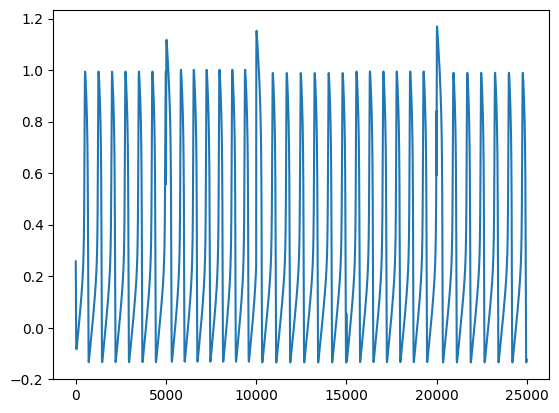

(90, 5000)


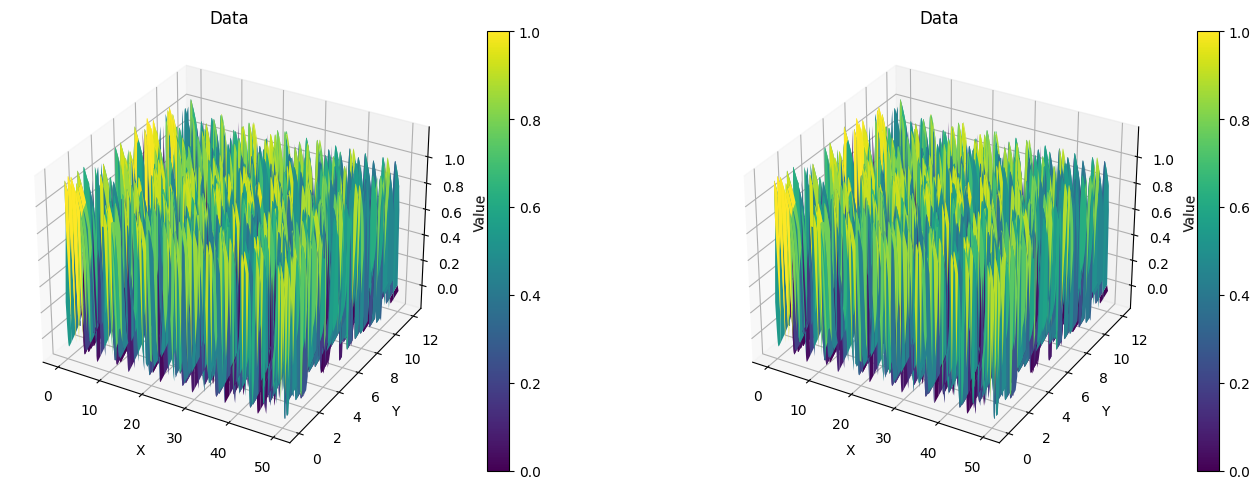

Gerando validaçao
overweriting
Generating dataset in ./training_data/validation/
(3, 10)
kernel call: ./a.out 500 0.01 10
239
Number of rows in the CSV file:  10 5001
Generated_set
[0.197655 0.205575 0.213559 0.221626 0.229794 0.238084 0.246514 0.255105
 0.263877 0.272853]


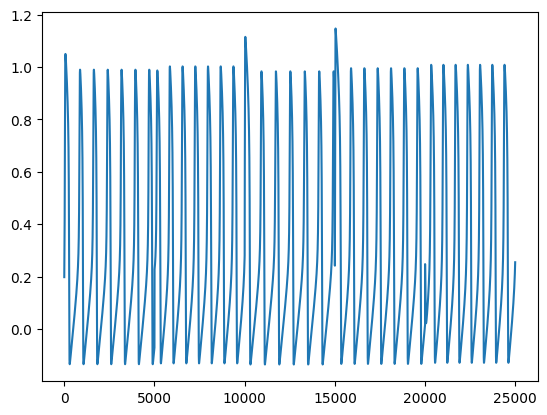

(10, 5000)


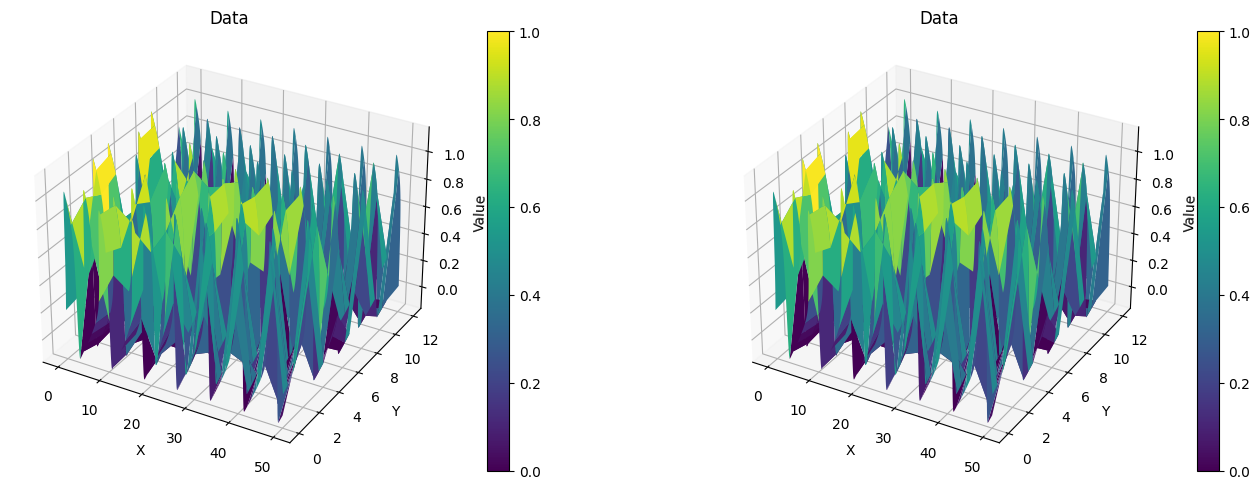

In [24]:
# Define the ranges
krange = [0, 1]
vrange = [0,1]
urange = [0, 1]
    # Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)

    
joint_dist = cp.J(u_dist,v_dist,k_dist)
T=1E2
sample_set = joint_dist.sample(T, rule="L").T
np.random.shuffle(sample_set)


sample_set=sample_set.T



print(sample_set.T[0])



print("Gerando treino ")
getDatasetFromDistA(sample_set[:,int(T*0.1):],data_folder="./training_data/treino/",ti=0,tf=500)
print("Gerando validaçao")
getDatasetFromDistA(sample_set[:,0:int(T*0.1)],data_folder="./training_data/validation/",ti=0,tf=500)

[0.3991598  0.10807377 0.92047026]
Gerando treino 
overweriting
Generating dataset in ./training_data/treinor/
(3, 4950)
kernel call: ./a.out 200 0.01 10
241
Number of rows in the CSV file:  4950 2001
Generated_set
[0.74968  0.764391 0.778974 0.793349 0.807437 0.821162 0.834449 0.847234
 0.859456 0.871069]


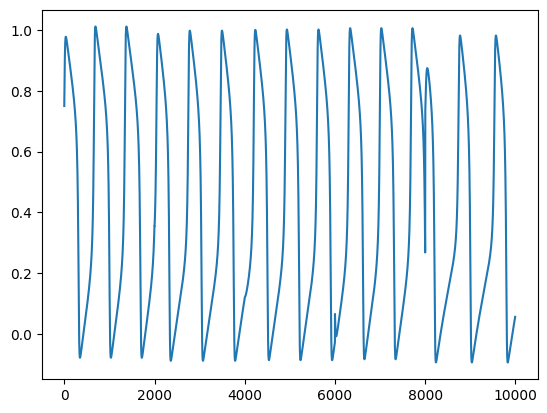

(4950, 2000)


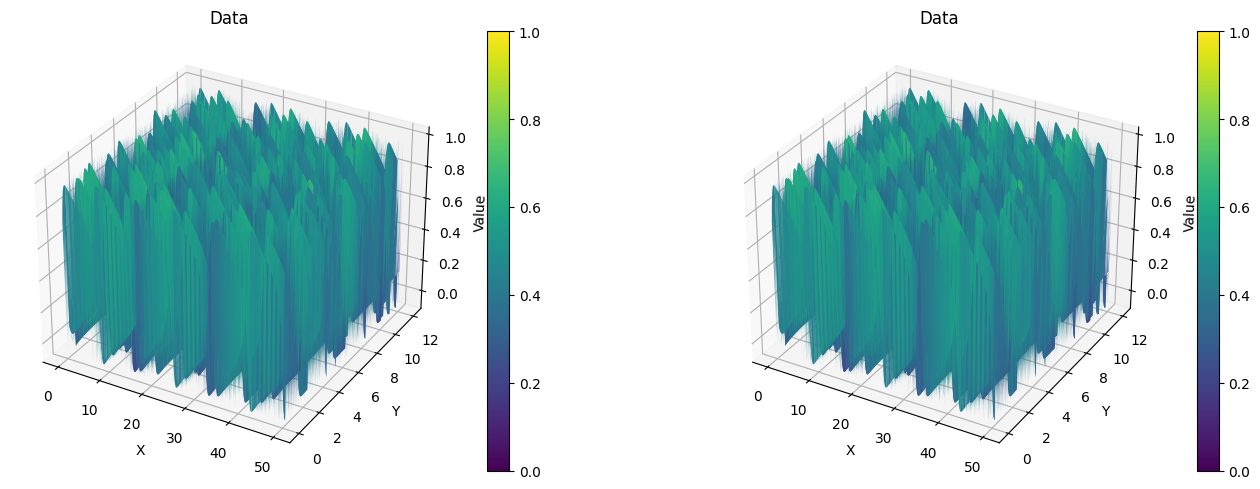

Gerando validaçao
overweriting
Generating dataset in ./training_data/validationr/
(3, 50)
kernel call: ./a.out 200 0.01 10
239
Number of rows in the CSV file:  50 2001
Generated_set
[0.397147 0.395045 0.392849 0.390557 0.388164 0.385667 0.383062 0.380345
 0.377512 0.374558]


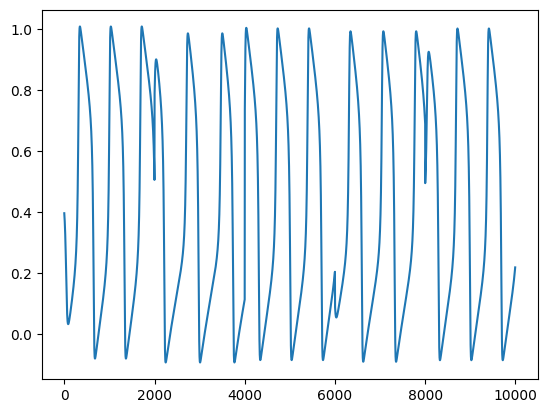

(50, 2000)


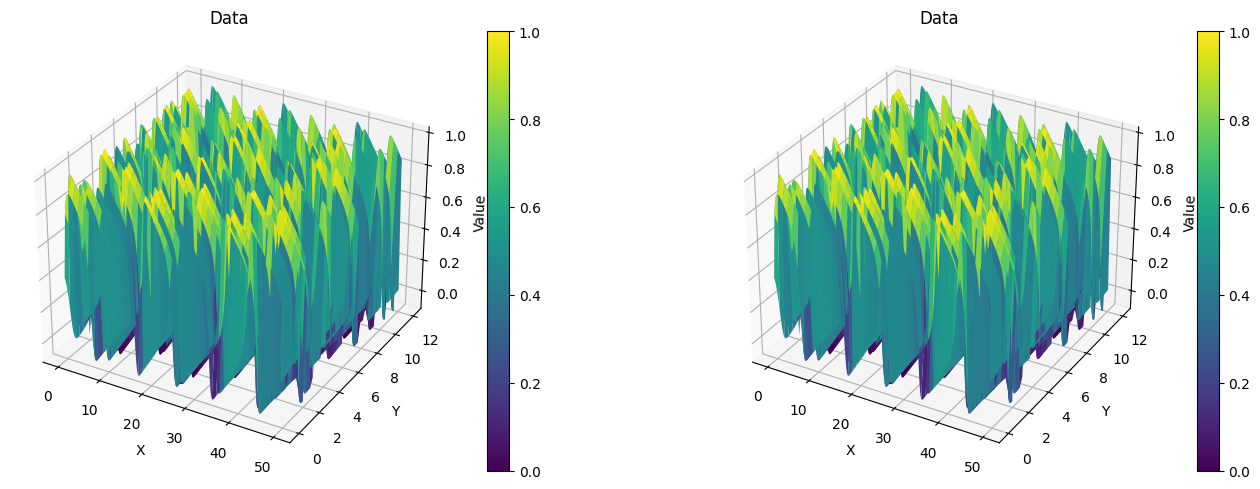

In [3]:
# Define the ranges
krange = [0., 1]
vrange = [0.06, 0.12]
urange = [-.1, 0.81]
    # Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)

    
joint_dist = cp.J(u_dist,v_dist,k_dist)
T=5E3
sample_set = joint_dist.sample(T, rule="L").T
np.random.shuffle(sample_set)


sample_set=sample_set.T



print(sample_set.T[0])



print("Gerando treino ")
getDatasetFromDistA(sample_set[:,int(T*0.01):],data_folder="./training_data/treinor/",ti=0,tf=200)
print("Gerando validaçao")
getDatasetFromDistA(sample_set[:,0:int(T*0.01)],data_folder="./training_data/validationr/",ti=0,tf=200)

[0.2020822  0.07181163 0.55574087]
Gerando monitores 
overweriting
Generating dataset in ./training_data/monitor/
(3, 500)
kernel call: ./a.out 200 0.01 100
238
Number of rows in the CSV file:  500 201
Generated_set
[0.177214 0.154725 0.136654 0.123976 0.116582 0.113703 0.11436  0.117659
 0.122899 0.129576]


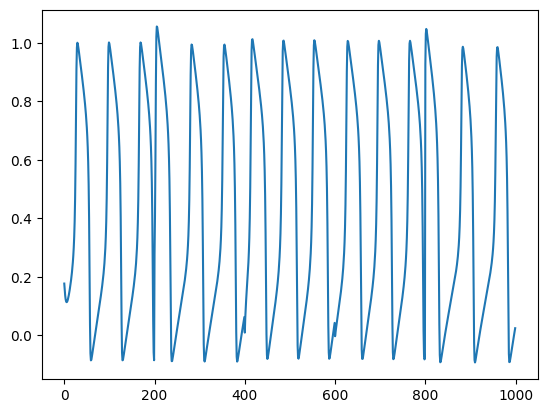

(500, 200)


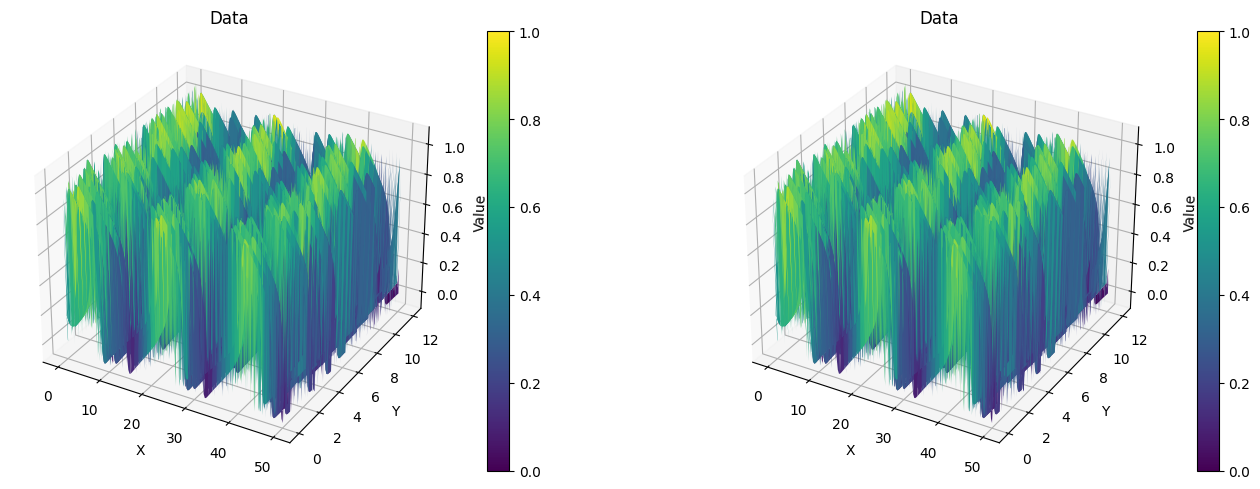

In [11]:
# Define the ranges
krange = [0., 1]
vrange = [0., 0.12]
urange = [-.1, 0.81]
    # Create uniform distributions
k_dist = cp.Uniform(*krange)
v_dist = cp.Uniform(*vrange)
u_dist = cp.Uniform(*urange)

    
joint_dist = cp.J(u_dist,v_dist,k_dist)
T=5E2
sample_set = joint_dist.sample(T, rule="L").T
np.random.shuffle(sample_set)


sample_set=sample_set.T



print(sample_set.T[0])



print("Gerando monitores ")
getDatasetFromDistA(sample_set,data_folder="./training_data/monitor/",ti=0,tf=200,r=10)

(3, 16)
(3, 3200)
Gerando treino region
overweriting
Generating dataset in ./training_data/treinocr/
(3, 3200)
kernel call: ./a.out 200 0.01 50
240
Number of rows in the CSV file:  3200 401
Generated_set
[0.787922 0.835236 0.873851 0.90209  0.920603 0.931331 0.936438 0.937738
 0.936548 0.933759]


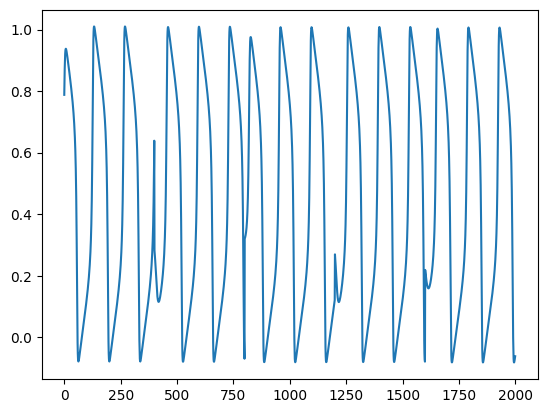

(3200, 400)


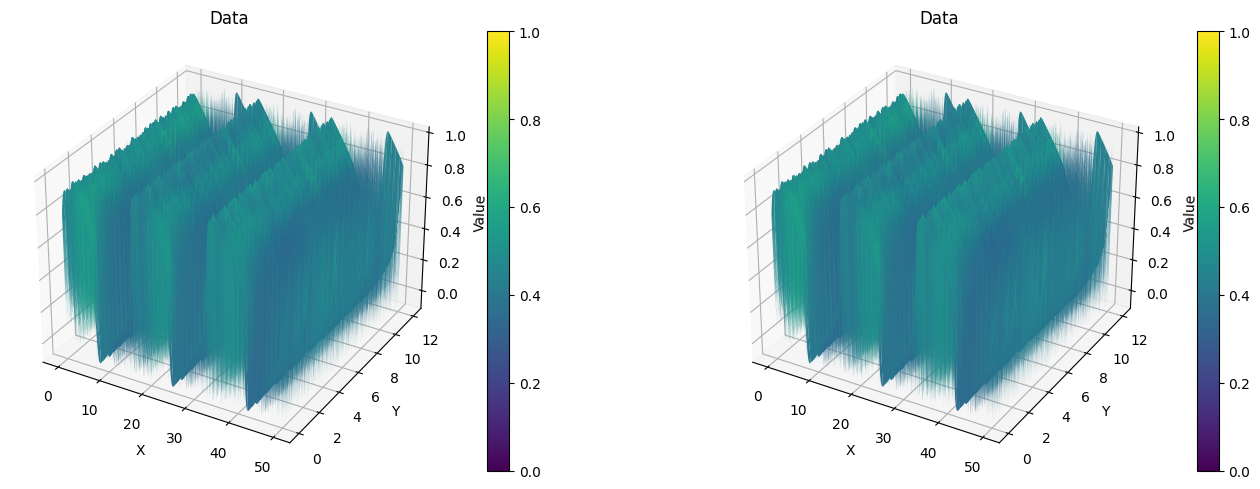

In [5]:
x_values = []
y_values = []
z_values = []

with open("data.txt", "r") as file:
    # Read each line in the file
    for line in file:
        #print(line)
        # Split the line into individual values
        values = line.strip().split(",")
        # Extract and convert the values to appropriate data types
        x_values.append(float(values[0]))
        y_values.append(float(values[1]))
        z_values.append(float(values[2]))

        

sample_set = np.stack((x_values, y_values, z_values), axis=0)
print(np.shape(sample_set))

sample_set=np.tile(sample_set, ( 1, int(2e2)))
print(np.shape(sample_set))
epsilon = 0.001  # Perturbation magnitude
perturbation = np.random.uniform(-epsilon, epsilon, sample_set.shape)
sample_set = sample_set + perturbation

print("Gerando treino region")
##Lista
getDatasetFromDistA(sample_set,data_folder="./training_data/treinocr/",ti=0,tf=200,r=5,deltaT=0.01)

